In this notebook, I build the teleportation circuit and add different types of noise to observe how this affects the fidelity

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import Initialize
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace, random_statevector, state_fidelity
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import Initialize
from qiskit.quantum_info import Statevector, DensityMatrix, random_statevector, state_fidelity
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

In [2]:
# build the 3-qubit teleportation circuit with coherent corrections ---
def build_teleportation_circuit(random_vec):
    """
    Qubits: q0=input, q1=Alice, q2=Bob.
    Uses coherent corrections (CX controlled by q1, CZ controlled by q0),
    so there are no classical conditionals.
    """
    psi = QuantumRegister(1, 'psi')
    bell = QuantumRegister(2, 'bell')
    qc = QuantumCircuit(psi, bell)

    # Prepare |psi> on q0
    qc.append(Initialize(random_vec), [psi[0]])

    # Create Bell pair between q1 and q2
    qc.h(bell[0])
    qc.cx(bell[0], bell[1])

    # Bell measurement operations (without measuring)
    qc.cx(psi[0], bell[0])
    qc.h(psi[0])

    # Coherent corrections (equivalent to classical corrections)
    qc.cx(bell[0], bell[1])   # X on Bob if q1 == 1
    qc.cz(psi[0], bell[1])    # Z on Bob if q0 == 1

    return qc  # Bob is bell[1] (global qubit index 2)


In [3]:
# Implementing depolarising noise
# --- sweep depolarizing probability and compute fidelities ---
fidelities = []
p_vals = np.linspace(0.0, 0.3, 100)

In [4]:
for p in p_vals:
    p1 = float(p)              # 1-qubit depol prob
    p2 = float(min(2*p, 1.0))  # 2-qubit depol prob (your original 2*p scaling)

    # Fresh noise model for this p
    noise_model = NoiseModel()
    # Apply depolarizing to common 1q gates used after transpile
    error_1q = depolarizing_error(p1, 1)
    noise_model.add_all_qubit_quantum_error(error_1q, ['x','y','z','h','sx','id','rx','ry','rz','p'])
    # Apply to CX
    error_2q = depolarizing_error(p2, 2)
    noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

    # Random input state
    random_vec = random_statevector(2)

    # Build teleportation circuit
    qc_clean = build_teleportation_circuit(random_vec)

    # --- Ideal Bob (no noise) ---
    ideal_sv = Statevector.from_instruction(qc_clean)
    # Trace out q0 and q1 (indices 0 and 1), leaving Bob (index 2)
    ideal_bob = partial_trace(ideal_sv, [0, 1])

    # --- Noisy Bob (Aer density-matrix sim with noise) ---
    sim = AerSimulator(method='density_matrix', noise_model=noise_model)
    qc_noisy = qc_clean.copy()
    # Save Bob's reduced density matrix directly
    qc_noisy.save_density_matrix(qubits=[2])

    tqc = transpile(qc_noisy, sim)
    res = sim.run(tqc).result()
    rho_bob = res.data(0)['density_matrix']  # 2x2 density matrix (Bob only)
    noisy_bob = DensityMatrix(rho_bob)

    # Fidelity between ideal and noisy Bob
    fidelities.append(state_fidelity(ideal_bob, noisy_bob))


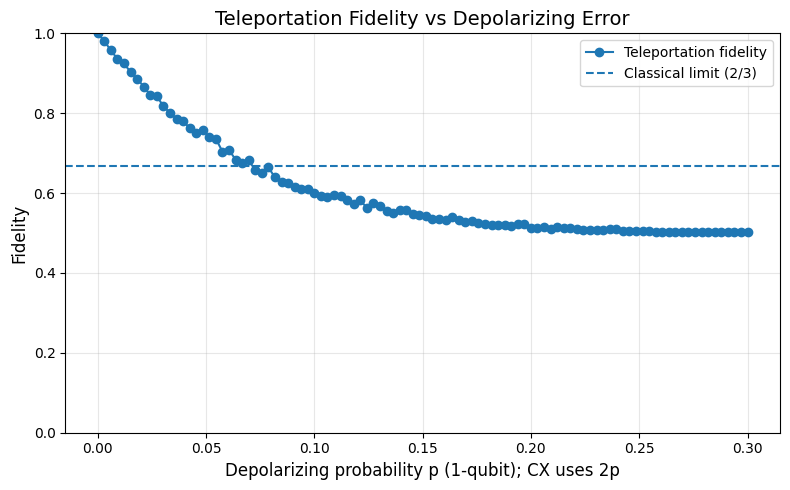

In [5]:
# --- plot ---
plt.figure(figsize=(8,5))
plt.plot(p_vals, fidelities, marker='o', linestyle='-', label='Teleportation fidelity')
plt.axhline(2/3, linestyle='--', label='Classical limit (2/3)')

plt.xlabel("Depolarizing probability p (1-qubit); CX uses 2p", fontsize=12)
plt.ylabel("Fidelity", fontsize=12)
plt.title("Teleportation Fidelity vs Depolarizing Error", fontsize=14)
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Now we must reintroduce measurements and control flow to the circuit and add readout error to observe how this affects the fidelity

In [6]:
# --- circuit with measurements + classically conditioned corrections ---
def teleportation_circuit_meas(random_vec):
    """
    Qubits: q0=input, q1=Alice, q2=Bob.
    Measures c[0]=q0, c[1]=q1, then applies classically-controlled X/Z on Bob.
    Saves Bob's density matrix at the end.
    """
    q = QuantumRegister(3, "q")
    c = ClassicalRegister(2, "c")  # c[0] LSB (meas q0), c[1] MSB (meas q1)
    qc = QuantumCircuit(q, c)

    # Prepare |psi> on q0
    qc.append(Initialize(random_vec), [q[0]])

    # Create Bell pair
    qc.h(q[1]); qc.cx(q[1], q[2])

    # Bell measurement
    qc.cx(q[0], q[1]); qc.h(q[0])
    qc.measure(q[0], c[0])
    qc.measure(q[1], c[1])

    # Classically-conditioned corrections (value = c[1]*2 + c[0])
    with qc.if_test((c, 0)):  # 00 -> I
        pass
    with qc.if_test((c, 1)):  # 01 -> X
        qc.x(q[2])
    with qc.if_test((c, 2)):  # 10 -> Z
        qc.z(q[2])
    with qc.if_test((c, 3)):  # 11 -> ZX
        qc.z(q[2]); qc.x(q[2])

    # Save Bob's reduced density matrix (qubit 2)
    qc.save_density_matrix(qubits=[2])
    return qc

In [7]:
# --- helper to average fidelity for a given noise model ---
def avg_fidelity_readout_sweep(noise_model, num_states=120, seed=1234):
    rng = np.random.default_rng(seed)
    sim = AerSimulator(method="density_matrix", noise_model=noise_model)
    fvals = []
    for _ in range(num_states):
        psi = random_statevector(2)
        qc = teleportation_circuit_meas(psi)
        tqc = transpile(qc, sim)
        res = sim.run(tqc).result()
        rho_bob = DensityMatrix(res.data(0)["density_matrix"])  # 2x2
        # Ideal Bob equals the input |psi⟩ in perfect teleportation:
        fvals.append(state_fidelity(psi, rho_bob))
    return float(np.mean(fvals))


In [14]:
# --- sweep settings ---
readout_probs = np.linspace(0.0, 0.30, 21)
num_states = 150
fixed_gate_p = 0.05   # set to 0.0 if you want no gate noise while sweeping readout


In [ ]:
# ---------- (A) Symmetric readout error sweep ----------
fids_sym = []
for p in readout_probs:
    nm = NoiseModel()
    # Optional fixed gate depolarizing
    if fixed_gate_p > 0:
        nm.add_all_qubit_quantum_error(depolarizing_error(fixed_gate_p, 1),
                                       ['x','y','z','h','sx','id','rx','ry','rz','p'])
        nm.add_all_qubit_quantum_error(depolarizing_error(min(2*fixed_gate_p,1.0), 2),
                                       ['cx'])
    # Symmetric readout confusion
    ro = ReadoutError([[1-p, p],
                       [p, 1-p]])
    nm.add_all_qubit_readout_error(ro)

    fids_sym.append(avg_fidelity_readout_sweep(nm, num_states=num_states))


In [ ]:
# ---------- (B) Antisymmetric readout error sweep ----------
# Example matrix: only 0->1 flips with prob p (tweak as you like)
fids_anti = []
for p in readout_probs:
    nm = NoiseModel()
    if fixed_gate_p > 0:
        nm.add_all_qubit_quantum_error(depolarizing_error(fixed_gate_p, 1),
                                       ['x','y','z','h','sx','id','rx','ry','rz','p'])
        nm.add_all_qubit_quantum_error(depolarizing_error(min(2*fixed_gate_p,1.0), 2),
                                       ['cx'])

    ro = ReadoutError([[1-p, p],
                       [0.0, 1.0]])
    nm.add_all_qubit_readout_error(ro)

    fids_anti.append(avg_fidelity_readout_sweep(nm, num_states=num_states))


In [ ]:
# --- plot ---
plt.figure(figsize=(8,5))
plt.plot(readout_probs, fids_sym, marker='o', linestyle='-', label='Symmetric readout error')
plt.plot(readout_probs, fids_anti, marker='s', linestyle='--', label='Antisymmetric readout error')
plt.axhline(2/3, linestyle=':', label='Classical limit (2/3)')

subtitle = f"(fixed gate depolarizing p={fixed_gate_p})" if fixed_gate_p>0 else "(no gate depolarizing)"
plt.title(f"Teleportation Fidelity vs Readout Error {subtitle}", fontsize=14)
plt.xlabel("Readout flip probability p", fontsize=12)
plt.ylabel("Average teleportation fidelity", fontsize=12)
plt.ylim(0.5, 1.02)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
